In [1]:
# !pip install -U tensorflow-text==2.5

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.3


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# import tensorflow_hub as hub

# # from bert import bert_tokenization
# # import tokenizer

In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing"
df=pd.read_csv(path +  '/dataset/created/cleaned_df.csv')
df = df.drop(['text'], axis =1)
df.head()

,label,cleaned_text
0,1,always make feel worthless sudden im problem
1,1,closer kill everyday famsquad mean im also clo...
2,1,know life hit hard knock fuck thats rn like ta...
3,1,reply actually make sick end yet theyll first ...
4,1,easy alone im tire alone


In [7]:
df = df.dropna(how='any',axis=0) 

In [8]:
df.isnull().any()

label           False
cleaned_text    False
dtype: bool

In [9]:
#split the data in train, validation, test
from sklearn.model_selection import train_test_split
def dataset_split(headlines,category):

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

df.clean_text=df.cleaned_text.astype(str)

X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(df.clean_text,df.label)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 49156 
	Training		 39816 
	Test			 4916 
	Validation		 4424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [10]:

# X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'],df['label'], test_size=0.1, stratify=df['label'], random_state=0)

In [11]:
X_train.head(4)

8578     dont want hear shit anymore piss point matter ...
1748                                   first wrong tonight
5304     get legit sad clint losestm like poor man noth...
29710    ace prize win fan make vid best single release...
Name: cleaned_text, dtype: object

In [12]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = y_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_valid = X_valid.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_valid = y_valid.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']



In [15]:
accuracy_threshold = 0.99
tf.keras.backend.clear_session()
#callback function for early stopping
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
filepath ="/content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/Bert.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='auto')
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.1, patience=2, 
                                    verbose=1, mode='auto', 
                                    min_delta=0.0001, cooldown=1, min_lr=0.000001)
callback_list = [acc_callback, checkpoint,reduceLROnPlat]

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dense(64, activation='relu')(outputs['pooled_output'])
l = tf.keras.layers.Dropout(0.2, name="dropout1")(l)
l = tf.keras.layers.Dense(64, activation='relu')(l)
l = tf.keras.layers.Dropout(0.2, name="dropout2")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [19]:
num_epochs = 10
batch = 128

BERT_history = model.fit(X_train, y_train, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(X_valid, y_valid), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/10
312/312 [==============================] - 1187s 4s/step - loss: 0.6290 - accuracy: 0.6355 - precision: 0.6362 - recall: 0.6286 - val_loss: 0.6998 - val_accuracy: 0.5683 - val_precision: 0.5303 - val_recall: 0.9856

Epoch 00001: val_accuracy improved from -inf to 0.56826, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/Bert.h5
Epoch 2/10
312/312 [==============================] - 941s 3s/step - loss: 0.5676 - accuracy: 0.7040 - precision: 0.7075 - recall: 0.6929 - val_loss: 0.5251 - val_accuracy: 0.7561 - val_precision: 0.7725 - val_recall: 0.7068

Epoch 00002: val_accuracy improved from 0.56826 to 0.75610, saving model to /content/drive/MyDrive/Colab Notebooks/Suicide Ideation Detection using natural Language Processing/model/Bert.h5
Epoch 3/10
312/312 [==============================] - 1177s 4s/step - loss: 0.5541 - accuracy: 0.7219 - precision: 0.7352 - recall: 0.6914 - val_loss: 0.5203 - val_accura

In [20]:
model.evaluate(X_test, y_test)

154/154 [==============================] - 121s 786ms/step - loss: 0.4768 - accuracy: 0.7750 - precision: 0.7730 - recall: 0.7761


[0.476772665977478, 0.7750203609466553, 0.7729861736297607, 0.7761437892913818]

In [21]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [23]:
import numpy as np
predicted = np.where(y_predicted > 0.5, 1, 0)
predicted

array([1, 0, 0, ..., 0, 1, 0])

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      2468
           1       0.77      0.78      0.77      2448

    accuracy                           0.78      4916
   macro avg       0.78      0.78      0.78      4916
weighted avg       0.78      0.78      0.78      4916



In [35]:
from matplotlib import pyplot as plt
import seaborn as sn


In [31]:
# Plot training results
def model_evaluate(history):
  H = history.history
  fig = plt.figure(figsize = (30, 8))
  plt.subplot(121)
  plt.xlabel("number of epoch")
  plt.ylabel("accuracy")
  plt.plot(H['accuracy'], label = 'training accuracy', marker='o')
  plt.plot(H['val_accuracy'], label = 'val accuracy',marker='o')
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size':20})
  # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),prop={'size': 15},
  #         fancybox=True, shadow=True, ncol=5)
  plt.subplot(122)
  plt.xlabel("number of epoch")
  plt.ylabel("loss")
  plt.plot(H['loss'], label = 'training loss',marker='o')
  plt.plot(H['val_loss'], label = 'val loss',marker='o')
  plt.xticks( rotation=0, weight = 'bold', )
  plt.yticks( rotation=0, weight = 'bold')
  plt.tick_params(rotation=0,axis='y', labelsize=15)
  plt.tick_params(rotation=0,axis='x', labelsize=18)
  plt.grid('white')
  plt.legend(prop={'size':20})


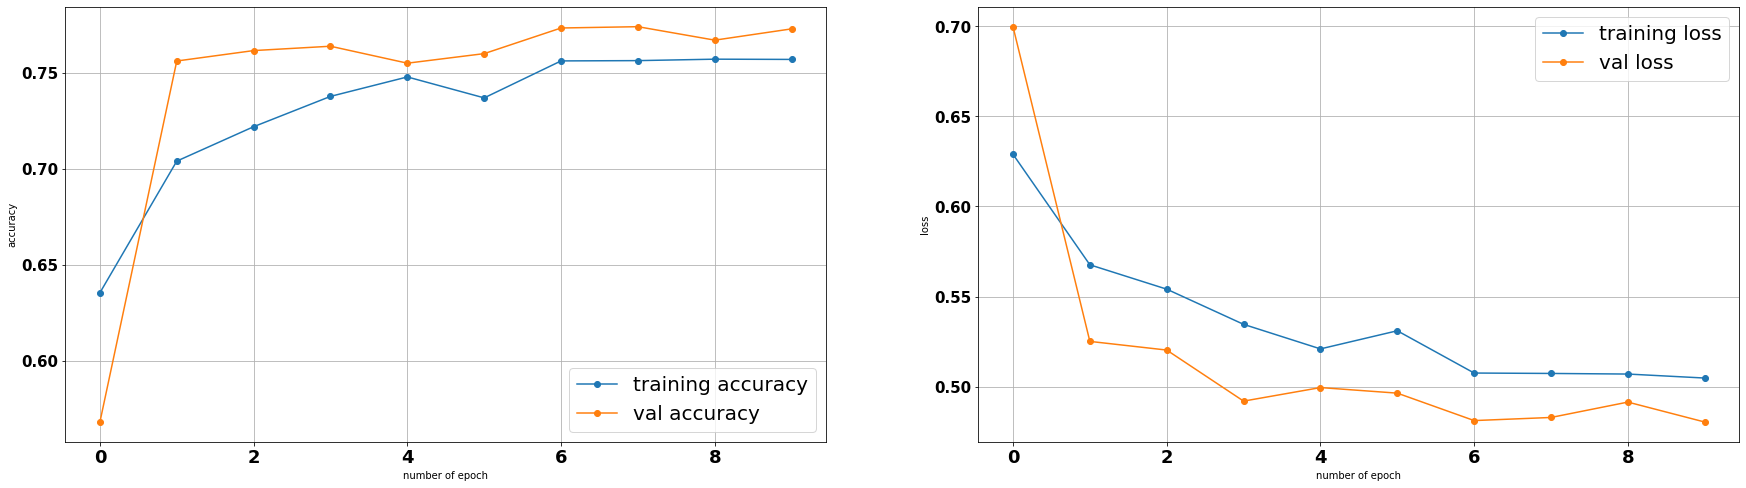

In [32]:
model_evaluate(BERT_history)

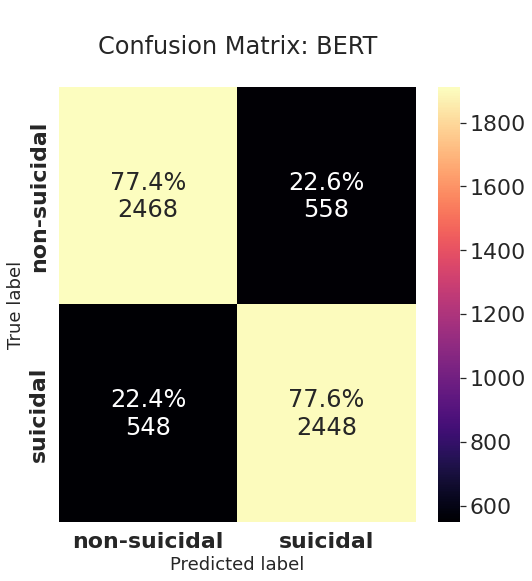

In [34]:
#confusion matrix
def conf_matrix(y_pred,classfier,figsize=(8,8)):
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d' % (p, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=['non-suicidal', 'suicidal'], columns=['non-suicidal', 'suicidal'])
    sn.set(font_scale=2) # Adjust to fit
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sn.heatmap(cm, cmap= "magma", annot=annot, fmt='', ax=ax)
    plt.title('\n''Confusion Matrix: '+classfier+'\n')
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.xticks( rotation=0, weight = 'bold')
    plt.yticks( rotation=90, weight = 'bold')
    plt.show()
    plt.close()
conf_matrix(predicted, 'BERT')